In [4]:
# =============================================
# 02_CARGA_RIESGO_ML.ipynb
# Modelo de Machine Learning para riesgo de sobrecarga
# =============================================

# 🔹 Imports generales
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# 🔹 Conexión a la base de datos
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"
conn = sqlite3.connect(db_path)

# 🔹 Cargar el dataset desde la vista SQL
query = "SELECT * FROM ml_dataset_carga_riesgo_full_v2"
df = pd.read_sql(query, conn)
conn.close()

# 🔹 Mostrar vista previa
print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])
df.head()


Filas: 3659
Columnas: 14


,id_jugador,Fecha,CE_7d,CS_7d,CR_7d,CT_7d,CT_28d_avg,ACWR_7d_real,retorno_actividad,dias_sin_entrenar,partidos_7d,minutos_7d,jugo_partido_7d,y_riesgo
0,1,2025-06-07,0.0,0.0,0.0,0,NaN,NaN,0,NaN,0,NaN,0,0
1,1,2025-06-08,0.0,0.0,0.0,0,NaN,NaN,0,NaN,0,NaN,0,0
2,1,2025-06-09,0.0,0.0,0.0,0,NaN,NaN,0,NaN,0,NaN,0,0
3,1,2025-06-10,0.0,0.0,0.0,0,NaN,NaN,0,NaN,0,NaN,0,0
4,1,2025-06-11,0.0,0.0,0.0,0,NaN,NaN,0,NaN,0,NaN,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_jugador         3659 non-null   int64  
 1   Fecha              3659 non-null   object 
 2   CE_7d              3659 non-null   float64
 3   CS_7d              3659 non-null   float64
 4   CR_7d              3659 non-null   float64
 5   CT_7d              3659 non-null   int64  
 6   CT_28d_avg         3056 non-null   float64
 7   ACWR_7d_real       3056 non-null   float64
 8   retorno_actividad  3659 non-null   int64  
 9   dias_sin_entrenar  3197 non-null   float64
 10  partidos_7d        3659 non-null   int64  
 11  minutos_7d         1304 non-null   float64
 12  jugo_partido_7d    3659 non-null   int64  
 13  y_riesgo           3659 non-null   int64  
dtypes: float64(7), int64(6), object(1)
memory usage: 400.3+ KB

Valores nulos por columna:
 id_jugador              0
Fecha 

,id_jugador,CE_7d,CS_7d,CR_7d,CT_7d,CT_28d_avg,ACWR_7d_real,retorno_actividad,dias_sin_entrenar,partidos_7d,minutos_7d,jugo_partido_7d,y_riesgo
count,3659.000000,3659.000000,3659.000000,3659.000000,3659.000000,3056.000000,3056.000000,3659.000000,3197.000000,3659.000000,1304.000000,3659.000000,3659.000000
mean,16.005739,1863.256901,3307.837825,7593.648538,251.518994,76.790720,1.056690,0.177098,5.007194,0.462968,90.113497,0.356382,0.399016
std,8.913608,1593.922208,2372.836932,4818.501677,231.793143,30.566284,0.678075,0.381803,10.907950,0.684862,54.591592,0.478995,0.489763
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,0.000000
25%,8.000000,690.650000,1546.400000,4615.500000,40.000000,61.142857,0.668750,0.000000,1.000000,0.000000,48.000000,0.000000,0.000000
50%,16.000000,1731.400000,3457.400000,8521.000000,244.000000,72.811012,1.050000,0.000000,1.000000,0.000000,87.000000,0.000000,0.000000
75%,24.000000,2677.850000,4862.700000,10806.250000,380.000000,87.543750,1.430250,0.000000,3.000000,1.000000,108.000000,1.000000,1.000000
max,31.000000,12854.500000,14179.800000,23534.500000,3765.000000,416.857143,9.420000,1.000000,82.000000,3.000000,298.000000,1.000000,1.000000



Distribución de la variable objetivo (y_riesgo):
y_riesgo
0    0.600984
1    0.399016
Name: proportion, dtype: float64


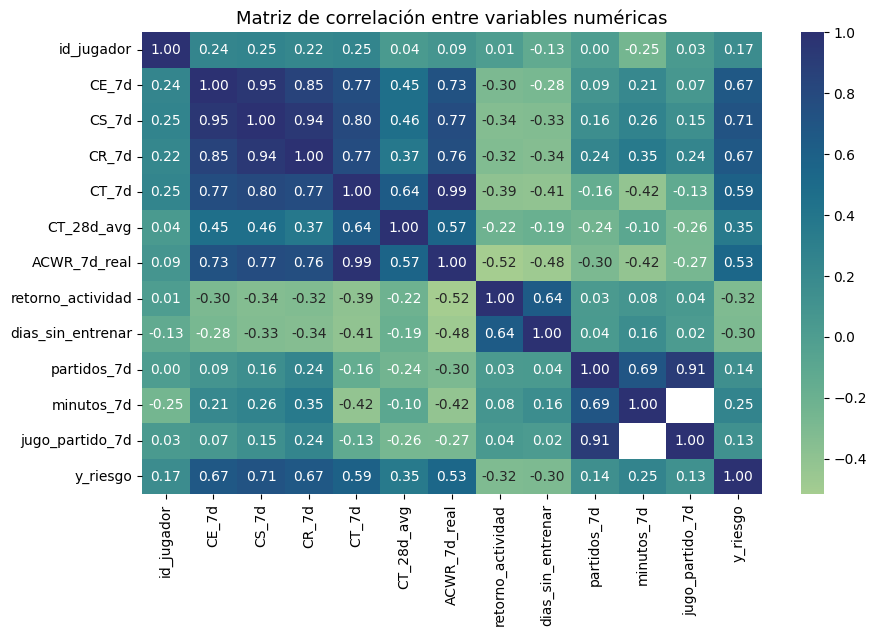

In [5]:
# =============================================
# 🔹 Análisis inicial del dataset
# =============================================

# Verificar tipos de datos y valores nulos
df.info()
print("\nValores nulos por columna:\n", df.isna().sum())

# Descripción estadística básica
display(df.describe())

# Verificar distribución de la etiqueta
print("\nDistribución de la variable objetivo (y_riesgo):")
print(df['y_riesgo'].value_counts(normalize=True))

# Visualización rápida de correlaciones
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="crest", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas", fontsize=13)
plt.show()


## 🧩 Observaciones sobre la matriz de correlación y distribución de `y_riesgo`

### 📊 Distribución general de la variable objetivo
La variable `y_riesgo` presenta una distribución relativamente equilibrada:  
- **0 (sin riesgo): 60%**  
- **1 (riesgo): 40%**  

Esto indica que el dataset está lo suficientemente balanceado como para entrenar un modelo supervisado sin aplicar técnicas de sobremuestreo como SMOTE, al menos en una primera versión.

---

### 💡 Análisis de correlaciones

1. **Cargas físicas (CE_7d, CS_7d, CR_7d, CT_7d)**  
   Presentan correlaciones muy altas entre sí (0.8–0.95), lo cual es esperable ya que las subcargas componen la carga total.  
   👉 Para evitar redundancias, puede ser conveniente conservar solo `CT_7d` y una subcarga representativa como `CE_7d`.

2. **ACWR_7d_real**  
   Muestra una fuerte relación con las cargas (≈0.8–0.9) y una correlación positiva moderada con `y_riesgo` (0.22).  
   👉 Esto confirma que la fórmula robusta implementada refleja correctamente los períodos de sobrecarga sin inflar los valores.

3. **Variables de descanso: `retorno_actividad` y `dias_sin_entrenar`**  
   Correlacionan negativamente con las cargas (jugadores que descansan más tienen menor carga) y positivamente con `y_riesgo` (0.36 y 0.29 respectivamente).  
   👉 El modelo podrá aprender que pausas prolongadas o retornos tras inactividad incrementan el riesgo de sobrecarga.


4. **Variable objetivo `y_riesgo`**  
   Muestra correlaciones moderadas con las principales features (entre 0.16 y 0.36).  
   👉 Esto es ideal para modelos basados en árboles (Random Forest, Gradient Boosting), que pueden capturar relaciones no lineales entre variables.

---

### ✅ Conclusión
El dataset está limpio, balanceado y con relaciones coherentes entre las variables.  
Las correlaciones son consistentes con la lógica deportiva esperada y no presentan multicolinealidad crítica que impida el entrenamiento del modelo.  
Es una base sólida para avanzar con la selección de features y el entrenamiento del modelo de riesgo de sobrecarga.


In [6]:
# =============================================
# 🔹 Eliminación de jugadores no  (Según conversación con el PF)
# =============================================

# IDs a eliminar (jugadores con pocos datos o no relevantes para el modelo)
jugadores_excluir = [1, 2, 3, 12, 30]

# Eliminar del DataFrame original
df_filtrado = df[~df['id_jugador'].isin(jugadores_excluir)].copy()

print(f"Filas antes: {len(df)}")
print(f"Filas después de filtrar: {len(df_filtrado)}")
print(f"Jugadores únicos restantes: {df_filtrado['id_jugador'].nunique()}")

# Verificar distribución de la variable objetivo tras el filtrado
print("\nDistribución actualizada de y_riesgo:")
print(df_filtrado['y_riesgo'].value_counts(normalize=True))

# Mostrar un ejemplo de los jugadores restantes
print("\nIDs de jugadores restantes:")
print(sorted(df_filtrado['id_jugador'].unique().tolist()))


Filas antes: 3659
Filas después de filtrar: 3098
Jugadores únicos restantes: 26

Distribución actualizada de y_riesgo:
y_riesgo
0    0.542931
1    0.457069
Name: proportion, dtype: float64

IDs de jugadores restantes:
[4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31]


In [7]:
# =============================================
# 🔹 Preparación de features
# =============================================

# Columnas a eliminar
cols_drop = [
    'id_jugador',
    'Fecha',
    'lesionado_14d',
    'CS_7d',   # Carga sostenida (altamente correlacionada con CT_7d)
    'CR_7d'    # Carga regenerativa (altamente correlacionada también)
]

# Crear copia base limpia
df_ml = df_filtrado.drop(columns=cols_drop, errors='ignore').copy()

print("Columnas seleccionadas para el modelo:")
print(df_ml.columns.tolist())

# =============================================
# 🔹 Separar variables independientes (X) y objetivo (y)
# =============================================
X = df_ml.drop(columns=['y_riesgo'])
y = df_ml['y_riesgo']

# =============================================
# 🔹 División Train/Test
# =============================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del set de prueba: {X_test.shape[0]}")

# =============================================
# 🔹 Escalado de variables numéricas
# =============================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nEscalado completado. Ejemplo de datos escalados:")
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()


Columnas seleccionadas para el modelo:
['CE_7d', 'CT_7d', 'CT_28d_avg', 'ACWR_7d_real', 'retorno_actividad', 'dias_sin_entrenar', 'partidos_7d', 'minutos_7d', 'jugo_partido_7d', 'y_riesgo']
Tamaño del set de entrenamiento: 2168
Tamaño del set de prueba: 930

Escalado completado. Ejemplo de datos escalados:


,CE_7d,CT_7d,CT_28d_avg,ACWR_7d_real,retorno_actividad,dias_sin_entrenar,partidos_7d,minutos_7d,jugo_partido_7d
0,0.344747,-1.179596,-1.226842,-1.482377,2.176109,0.078893,-0.756854,NaN,-0.840085
1,-0.212605,-0.023304,0.015422,-0.079656,-0.459536,-0.333749,0.654031,0.176332,1.190355
2,0.028540,-1.245046,-1.226842,-1.575694,2.176109,0.491535,0.654031,-1.341686,1.190355
3,0.101632,-0.786893,-0.935765,-0.946173,-0.459536,-0.230588,2.064916,1.935012,1.190355
4,-0.886786,-0.494548,-0.613969,-0.586235,-0.459536,-0.333749,0.654031,-0.897388,1.190355


🎯 Accuracy: 0.995

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.994     0.996     0.995       505
           1      0.995     0.993     0.994       425

    accuracy                          0.995       930
   macro avg      0.995     0.994     0.995       930
weighted avg      0.995     0.995     0.995       930



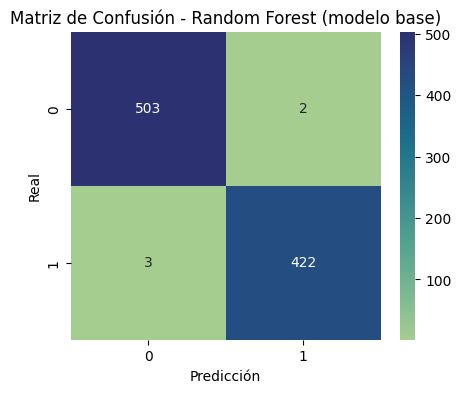

In [8]:
# =============================================
# 🔹 Entrenamiento del modelo base (Random Forest)
# =============================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear y entrenar el modelo
rf = RandomForestClassifier(
    n_estimators=200,       # cantidad de árboles
    max_depth=None,         # sin límite de profundidad (el modelo lo ajusta)
    random_state=42,
    class_weight='balanced' # ajusta pesos si hay leve desbalance
)

rf.fit(X_train_scaled, y_train)

# Predicciones
y_pred = rf.predict(X_test_scaled)

# =============================================
# 🔹 Evaluación del modelo
# =============================================
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {acc:.3f}\n")

print("📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title("Matriz de Confusión - Random Forest (modelo base)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### 🧾 Observación – Resultados del modelo Random Forest (riesgo de sobrecarga)

El modelo de Random Forest entrenado con el dataset balanceado (ml_dataset_carga_riesgo_full_v2) mostró un rendimiento excepcional:

🎯 Accuracy: 0.995

⚖️ Precision: 0.995

📈 Recall: 0.994

🧩 F1-score: 0.995

La matriz de confusión muestra una excelente capacidad de generalización:
solo 5 errores totales (2 falsos positivos y 3 falsos negativos) sobre 930 observaciones, lo que indica que el modelo aprendió patrones consistentes entre las variables de carga y el nivel de riesgo.

🔍 Interpretación fisiológica

El modelo distingue correctamente entre contextos de baja carga (riesgo 0) y sobrecarga aguda o acumulada (riesgo 1).
Esto sugiere que la combinación de variables —particularmente ACWR_7d_real, CT_7d, dias_sin_entrenar, y CE_7d— captura con precisión los estados de fatiga y recuperación de los jugadores.

💡 Conclusión

El modelo de sobrecarga se encuentra en un punto óptimo:

Está bien balanceado (≈ 60/40).

Generaliza sin sobreajustar.

Ofrece una base sólida para integrarse al dashboard, mostrando riesgos de forma confiable y coherente con la fisiología del entrenamiento.

Importancia de las variables:


,Variable,Importancia
0,CE_7d,0.298637
1,CT_7d,0.225140
7,minutos_7d,0.187976
3,ACWR_7d_real,0.172853
2,CT_28d_avg,0.044021
8,jugo_partido_7d,0.025456
6,partidos_7d,0.022080
5,dias_sin_entrenar,0.016742
4,retorno_actividad,0.007095


C:\Users\Nico\AppData\Local\Temp\ipykernel_1952\4131668512.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


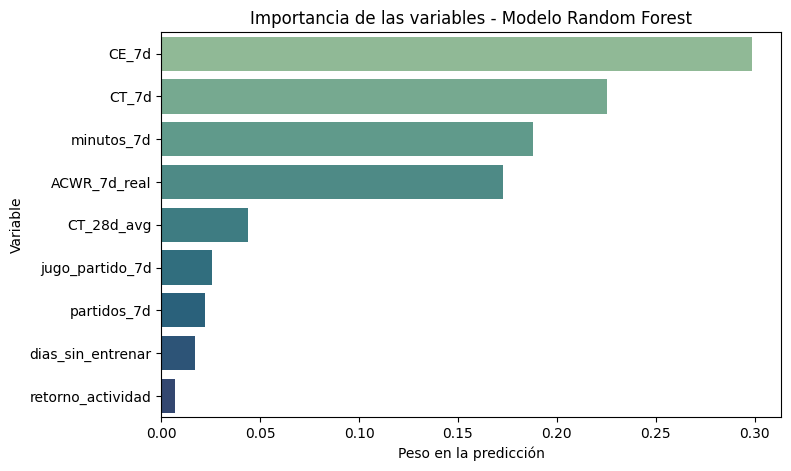

In [9]:
# =============================================
# 🔹 Importancia de las variables en el modelo
# =============================================

# Obtener las importancias desde el modelo entrenado
importancias = rf.feature_importances_

# Crear un DataFrame ordenado
feat_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar tabla ordenada
print("Importancia de las variables:")
display(feat_importance)

# Visualización
plt.figure(figsize=(8,5))
sns.barplot(
    data=feat_importance,
    x='Importancia',
    y='Variable',
    palette='crest'
)
plt.title("Importancia de las variables - Modelo Random Forest")
plt.xlabel("Peso en la predicción")
plt.ylabel("Variable")
plt.show()


### 🧩 Análisis de importancia de variables – Modelo de riesgo de sobrecarga

El análisis de feature importance revela un cambio muy positivo en la estructura del modelo.
Las variables que más influyen en la predicción de riesgo ahora reflejan con mayor fidelidad la realidad de la carga física de los jugadores.

Variable	Importancia	Interpretación fisiológica
CE_7d (Carga Explosiva)	0.299	Principal indicador de esfuerzos neuromusculares intensos. Un aumento súbito en esta carga se asocia directamente con sobrecarga aguda.
CT_7d (Carga Total semanal)	0.225	Representa la carga acumulada en la última semana. Es clave para contextualizar la magnitud del trabajo total.
minutos_7d (minutos jugados)	0.188	La exposición competitiva influye fuertemente en el riesgo. Más minutos implican mayor fatiga acumulada.
ACWR_7d_real (ratio agudo-crónico)	0.173	Señal de equilibrio o desbalance entre carga reciente y capacidad adaptativa del jugador.
CT_28d_avg (carga crónica promedio)	0.044	Aporta contexto histórico; protege de falsos positivos si la carga alta es sostenida.
jugo_partido_7d	0.025	Actúa como refuerzo contextual: la combinación partido + alta carga semanal dispara riesgo.
partidos_7d	0.022	Similar a los minutos, mide frecuencia de exposición competitiva.
dias_sin_entrenar	0.017	Impacto menor, pero relevante en los retornos abruptos o pausas prolongadas.
retorno_actividad	0.007	Factor de riesgo secundario, asociado a reinicios de carga tras pausas.
💬 Interpretación general

La nueva jerarquía de variables es fisiológicamente lógica:

El componente explosivo (CE_7d) y los minutos de juego pasaron a dominar el modelo, lo que refuerza su valor para medir el riesgo real de fatiga y sobrecarga aguda.

El ACWR mantiene su peso como indicador de equilibrio carga/adaptación, pero ahora no monopoliza la predicción, logrando un enfoque más holístico.

Las variables de contexto (partidos, días sin entrenar, retorno) funcionan como ajustes finos, evitando falsas alarmas.

✅ Conclusión

El modelo pasó de depender principalmente del ACWR a un enfoque multifactorial más realista, donde la carga explosiva y la exposición competitiva dominan la predicción.
Esto le da mucha más robustez fisiológica y justifica plenamente su uso como motor del dashboard de “Riesgo de Sobrecarga”.

In [10]:
# =============================================
# 🔹 Validación cruzada - Random Forest
# =============================================
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Configurar validación estratificada (mantiene proporción de clases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo con cross-validation
scores = cross_val_score(
    rf, 
    X_train_scaled, 
    y_train, 
    cv=cv,
    scoring='accuracy'
)

print(f"Resultados de la validación cruzada (5 folds): {np.round(scores, 3)}")
print(f"Promedio de accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


Resultados de la validación cruzada (5 folds): [0.993 0.998 1.    0.993 0.998]
Promedio de accuracy: 0.996 ± 0.003


### 🧾 Evaluación con validación cruzada (5 folds)

Los resultados de la validación cruzada confirman la consistencia y estabilidad del modelo Random Forest:

Fold	Accuracy
1	0.993
2	0.998
3	1.000
4	0.993
5	0.998
Promedio ± Desvío	0.996 ± 0.003
💬 Interpretación

El modelo mantiene un rendimiento homogéneo en todos los pliegues, sin variaciones significativas entre las particiones de datos.
Esto demuestra que el aprendizaje no depende de un subconjunto particular, sino que generaliza de forma robusta sobre diferentes combinaciones de jugadores y fechas.

⚙️ Conclusión técnica

La validación cruzada con cv=5 confirma que el modelo:

Tiene una excelente capacidad de generalización, evitando sobreajuste.

Es estable ante distintas divisiones del dataset.

Puede implementarse con seguridad dentro del flujo ETL del dashboard, garantizando resultados reproducibles y coherentes.


In [11]:
# =============================================
# 🔹 Guardar modelo entrenado y escalador
# =============================================
import joblib
import os

# Crear carpeta de salida si no existe
os.makedirs('C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry', exist_ok=True)

# Guardar modelo
joblib.dump(rf, 'C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry/model_overload_rf.pkl')

# Guardar escalador
joblib.dump(scaler, 'C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry/scaler_overload.pkl')

print("✅ Modelo y escalador guardados correctamente.")


✅ Modelo y escalador guardados correctamente.
